In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
# Use the cleaned, scaled dataset (best for clustering)
CLEAN = Path("/Users/nadaashraf/Heart_Disease_Project/data/cleaned_heart.csv")
assert CLEAN.exists(), f"Missing {CLEAN}. Run 01_data_preprocessing first."

df = pd.read_csv(CLEAN)
print("Cleaned shape:", df.shape)
df.head(3)


Cleaned shape: (920, 23)


,id,age,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,-1.730169,1.007386,0.705176,0.303643,True,0.489727,False,1.368109,-0.361400,0,...,False,False,False,True,False,False,False,False,False,False
1,-1.726404,1.432034,1.518569,0.789967,False,-1.181478,True,0.611589,4.411152,2,...,False,False,False,False,False,False,True,False,True,False
2,-1.722639,1.432034,-0.650479,0.266939,False,-0.345875,True,1.651804,2.820301,1,...,False,False,False,False,False,False,True,False,False,True


In [ ]:
assert "num" in df.columns, "Target 'num' not found."
X = df.drop(columns=["num"])
y = df["num"]          
y_bin = (y > 0).astype(int)  # disease vs no-disease for evaluation 

# Low-dim projection for plots only 
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X)
print("X:", X.shape, "| X_2d:", X_2d.shape)


X: (920, 22) | X_2d: (920, 2)


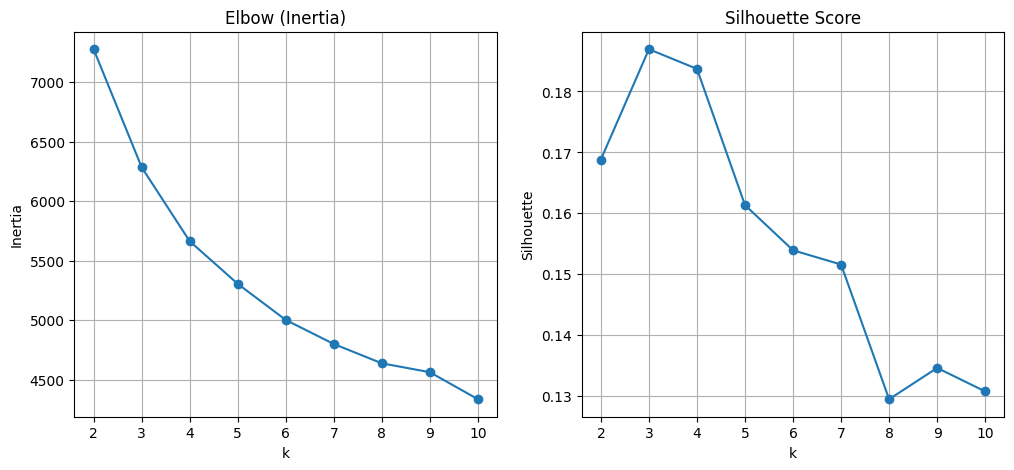

Chosen k (max silhouette): 3


In [ ]:
#K-Means: elbow and silhouette (choose K)
inertias, sils, ks = [], [], range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(list(ks), inertias, marker="o")
ax[0].set_title("Elbow (Inertia)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia"); ax[0].grid(True)
ax[1].plot(list(ks), sils, marker="o")
ax[1].set_title("Silhouette Score"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette"); ax[1].grid(True)
plt.show()

# Pick k by best silhouette 
k_best = int(ks[np.argmax(sils)])
print(f"Chosen k (max silhouette): {k_best}")


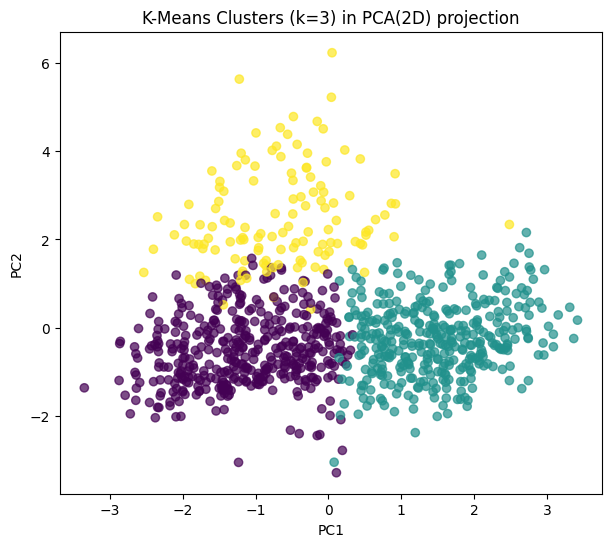

K-Means vs Binary (disease/no-disease): ARI=0.227, NMI=0.186
K-Means vs Multiclass (0..4)        : ARI=0.216, NMI=0.172


In [5]:
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init="auto")
cl_km = kmeans.fit_predict(X)

# Visualize clusters in 2D PCA space
plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=cl_km, alpha=0.7)
plt.title(f"K-Means Clusters (k={k_best}) in PCA(2D) projection")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Compare clusters with (a) binary labels and (b) 0..4 labels
ari_bin  = adjusted_rand_score(y_bin, cl_km)
nmi_bin  = normalized_mutual_info_score(y_bin, cl_km)
ari_multi = adjusted_rand_score(y, cl_km)
nmi_multi = normalized_mutual_info_score(y, cl_km)

print(f"K-Means vs Binary (disease/no-disease): ARI={ari_bin:.3f}, NMI={nmi_bin:.3f}")
print(f"K-Means vs Multiclass (0..4)        : ARI={ari_multi:.3f}, NMI={nmi_multi:.3f}")


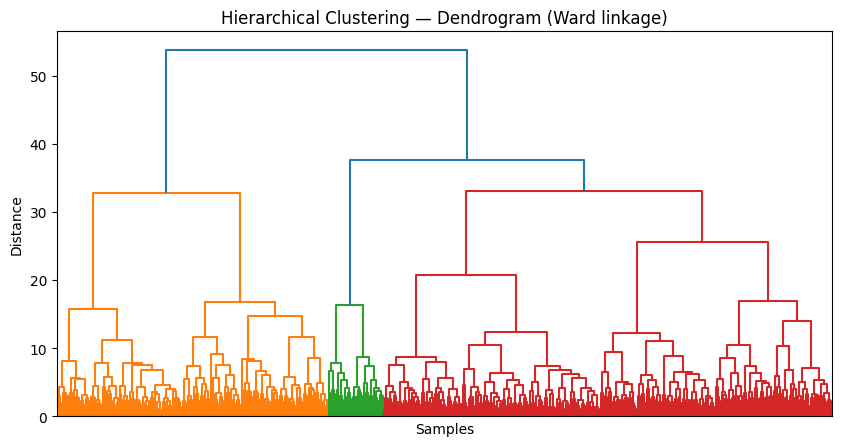

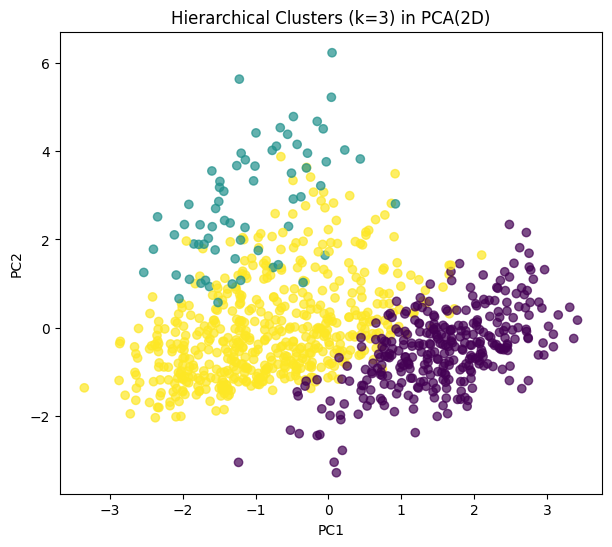

Hierarchical vs Binary:   ARI=0.125, NMI=0.115
Hierarchical vs Multiclass: ARI=0.178, NMI=0.123


In [ ]:

Z = linkage(X, method="ward")
plt.figure(figsize=(10,5))
dendrogram(Z, no_labels=True, count_sort=True)
plt.title("Hierarchical Clustering — Dendrogram (Ward linkage)")
plt.xlabel("Samples"); plt.ylabel("Distance")
plt.show()

# Cut the dendrogram at k_best clusters (same k as K-Means for consistency)
cl_hier = fcluster(Z, t=k_best, criterion="maxclust") - 1  

# Visualize in 2D PCA
plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=cl_hier, alpha=0.7)
plt.title(f"Hierarchical Clusters (k={k_best}) in PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Evaluate vs labels
ari_bin_h  = adjusted_rand_score(y_bin, cl_hier)
nmi_bin_h  = normalized_mutual_info_score(y_bin, cl_hier)
ari_multi_h = adjusted_rand_score(y, cl_hier)
nmi_multi_h = normalized_mutual_info_score(y, cl_hier)

print(f"Hierarchical vs Binary:   ARI={ari_bin_h:.3f}, NMI={nmi_bin_h:.3f}")
print(f"Hierarchical vs Multiclass: ARI={ari_multi_h:.3f}, NMI={nmi_multi_h:.3f}")


In [ ]:
summary = pd.DataFrame({
    "Method": ["KMeans","KMeans","Hierarchical","Hierarchical"],
    "Against": ["Binary","Multiclass","Binary","Multiclass"],
    "ARI": [ari_bin, ari_multi, ari_bin_h, ari_multi_h],
    "NMI": [nmi_bin, nmi_multi, nmi_bin_h, nmi_multi_h]
})
summary


,Method,Against,ARI,NMI
0,KMeans,Binary,0.227410,0.186420
1,KMeans,Multiclass,0.216074,0.171677
2,Hierarchical,Binary,0.125190,0.115270
3,Hierarchical,Multiclass,0.177507,0.122751
